In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv(r'/home/yuvraj/Coding/sih_main/AIS_2023_11_16.csv')

In [3]:
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,367677130,2023-11-16T00:00:01,46.14610,-123.03792,10.1,128.4,128.0,BARRY SILVERTON,IMO9792785,WDI2338,31.0,0.0,33.0,NaN,NaN,57.0,A
1,368102470,2023-11-16T00:00:01,30.07186,-90.89806,0.3,38.2,511.0,JOANNE C,NaN,WDK9314,52.0,0.0,23.0,8.0,3.0,52.0,A
2,316039288,2023-11-16T00:00:02,48.42285,-123.37079,0.0,324.3,294.0,CASCADIA,IMO8745216,CFA2941,60.0,0.0,42.0,13.0,2.2,60.0,A
3,367095450,2023-11-16T00:00:02,38.08289,-90.20293,0.0,257.2,309.0,DANNY ETHERIDGE,NaN,WDC8945,31.0,12.0,47.0,11.0,NaN,32.0,A
4,367666920,2023-11-16T00:00:02,27.83879,-97.50744,0.0,341.1,310.0,BILL SEYMOUR,NaN,WDH9328,31.0,0.0,27.0,NaN,NaN,31.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883821,367333430,2023-11-16T04:38:32,13.43293,144.66593,7.6,354.3,511.0,TUG GOLIATH,IMO7979231,WCY2815,52.0,15.0,33.0,10.0,0.0,52.0,A
7883822,367333430,2023-11-16T04:51:20,13.46135,144.66454,0.2,301.5,511.0,TUG GOLIATH,IMO7979231,WCY2815,52.0,15.0,33.0,10.0,0.0,52.0,A
7883823,400800353,2023-11-16T00:00:06,13.42219,144.66488,0.8,47.3,151.0,ROK GOV VESSEL,NaN,HLDNP9,0.0,0.0,0.0,0.0,0.0,0.0,A
7883824,400800353,2023-11-16T00:01:26,13.42243,144.66526,1.3,64.9,158.0,ROK GOV VESSEL,NaN,HLDNP9,0.0,0.0,0.0,0.0,0.0,0.0,A


In [4]:
def clean_sog(df):
    return df[(df['SOG'] <= 102.3) & (df['SOG'] >= 0)]

def clean_cog(df):
    return df[((df['COG'] >= 0) & (df['COG'] <= 360)) | (df['COG'] == 511)]

def remove_suspicious_records(df):
    mexico_bbox = {'min_lat': 18.0, 'max_lat': 31.0, 'min_lon': -100, 'max_lon': -80}
    
    # Sort data by MMSI and BaseDateTime
    df.sort_values(by=['MMSI', 'BaseDateTime'], inplace=True)
    
    # Flag points outside the suspicious bounding box
    df['In_Suspicious_Area'] = (
            (df['LAT'] < mexico_bbox['min_lat']) | (df['LAT'] > mexico_bbox['max_lat']) |
            (df['LON'] < mexico_bbox['min_lon']) | (df['LON'] > mexico_bbox['max_lon'])
        )

    # Remove suspicious records
    return df[~df['In_Suspicious_Area']]

def remove_zone_16(df):
    # Define the longitude bounds for UTM Zone 16
    zone_16_long = {
        'min_lon': -90,
        'max_lon': -84
    }
    
    # Sort data by MMSI and BaseDateTime
    df.sort_values(by=['MMSI', 'BaseDateTime'], inplace=True)
    
    # Flag points within the UTM Zone 16 longitude bounds
    df['In_UTM_Zone_16'] = (
        (df['LON'] >= zone_16_long['min_lon']) &
        (df['LON'] <= zone_16_long['max_lon'])
    )
    
    # Remove records within UTM Zone 16 based on longitude
    return df[df['In_UTM_Zone_16']]

def create_time_windows(df):
    df['TimeWindow'] = df['BaseDateTime'].dt.floor('20T')
    return df

# Define a function to calculate the mean heading correctly
def mean_heading(headings):
    x = np.mean(np.cos(np.radians(headings)))
    y = np.mean(np.sin(np.radians(headings)))
    return np.degrees(np.arctan2(y, x)) % 360

# Function to get the most common value (mode)
def mode(series):
    return series.mode()[0] if not series.mode().empty else np.nan

def categorize_time_of_day(df):
    """Categorize time of day into morning, afternoon, evening, night"""
    conditions = [
        (df['BaseDateTime'].dt.hour < 6),   # Night: before 6 AM
        (df['BaseDateTime'].dt.hour < 12),  # Morning: from 6 AM to before noon
        (df['BaseDateTime'].dt.hour < 18),  # Afternoon: from noon to before 6 PM
        (df['BaseDateTime'].dt.hour >= 18)   # Evening: from 6 PM onwards
    ]
    
    choices = ['Night', 'Morning', 'Afternoon', 'Evening']
    
    df['TimeOfDay'] = np.select(conditions, choices, default='Unknown')
    return df

def aggregate_data(df):
    """Aggregate data by MMSI and TimeWindow."""
    
    grouped = df.groupby(['MMSI', 'TimeWindow']).agg({
        'SOG': ['mean'],
        'COG': ['mean'],
        'LAT': ['mean'],
        'LON': ['mean'],
        'VesselType': [mode],
        'Heading': [mean_heading],
        'Cargo': [mode],
        'Status': [mode],
        'TimeOfDay': [mode]       # Mode for TimeOfDay if needed
    }).reset_index()

    # Flatten the column hierarchy resulting from the aggregation
    grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
    
    return grouped

def preprocessing_pipeline(df):
        
    # Preprocessing steps
    df.dropna(inplace=True)
    
    # Ensure BaseDateTime is in datetime format
    df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
    
    df = clean_sog(df)
    df = clean_cog(df)
    
    # Remove suspicious records based on distance criteria
    df = remove_suspicious_records(df)
    df = remove_zone_16(df)

    # Create time windows for aggregation
    df = create_time_windows(df)

    # Categorize time of day before aggregation
    df=categorize_time_of_day(df)

    # Aggregate data by MMSI and TimeWindow
    aggregated_df = aggregate_data(df)

    return aggregated_df


df.dropna(inplace=True)
result_df = preprocessing_pipeline(df)
result_df

/tmp/ipykernel_144467/506284464.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['TimeWindow'] = df['BaseDateTime'].dt.floor('20T')


,MMSI,TimeWindow,SOG_mean,COG_mean,LAT_mean,LON_mean,VesselType_mode,Heading_mean_heading,Cargo_mode,Status_mode,TimeOfDay_mode
0,209012000,2023-11-16 00:00:00,0.000000,232.857143,30.669199,-88.030043,70.0,332.000000,70.0,5.0,Night
1,209012000,2023-11-16 00:20:00,0.000000,139.333333,30.669190,-88.030035,70.0,332.000000,70.0,5.0,Night
2,209012000,2023-11-16 00:40:00,0.000000,2.000000,30.669198,-88.030010,70.0,332.000000,70.0,5.0,Night
3,209012000,2023-11-16 01:00:00,0.000000,196.857143,30.669183,-88.030016,70.0,332.000000,70.0,5.0,Night
4,209012000,2023-11-16 01:20:00,0.000000,352.000000,30.669098,-88.030062,70.0,332.000000,70.0,5.0,Night
...,...,...,...,...,...,...,...,...,...,...,...
9907,636092681,2023-11-16 06:00:00,10.800000,25.200000,29.842896,-89.986140,70.0,25.898753,70.0,0.0,Morning
9908,636092681,2023-11-16 06:20:00,10.488235,83.741176,29.873423,-89.954964,70.0,91.214791,70.0,0.0,Morning
9909,636092681,2023-11-16 06:40:00,10.016667,182.927778,29.880819,-89.908973,70.0,17.002332,70.0,0.0,Morning
9910,636092681,2023-11-16 07:00:00,10.023529,288.629412,29.919188,-89.935936,70.0,286.650329,70.0,0.0,Morning


In [5]:
import os
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
import warnings

warnings.filterwarnings("ignore")

class BiLSTM(nn.Module):
    def __init__(
        self,
        input_size=7,
        hidden_size=128,
        output_size=1,
        num_layers=2,
        dropout_rate=0.2,
    ):
        super(BiLSTM, self).__init__()  # Use super() for proper initialization
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)  # Bidirectional output size
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # LSTM forward pass
        out, _ = self.lstm(x)  # (batch_size, seq_length, hidden_size * 2)
        out = out[:, -1, :]  # (batch_size, hidden_size * 2)
        out = self.dropout(out)
        out = self.fc(out)
        return out.squeeze()  # Ensure output is 1D


class AnomalyDetector:
    def __init__(self, model_folder="/home/yuvraj/Coding/sih_main/lstm_model_7"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_folder = model_folder
        # Load the models and scaler
        self.scaler = self.load_scaler()
        self.label_encoder = self.load_encoder()
        self.model = self.load_model()

    def load_scaler(self):
        with open(os.path.join(self.model_folder, "scaler.pkl"), "rb") as f:
            return pickle.load(f)

    def load_encoder(self):
        with open(os.path.join(self.model_folder, "label_encoder.pkl"), "rb") as f:
            return pickle.load(f)

    def load_model(self):
        # Determine the device
        # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create model
        model = BiLSTM()

        # Load model to the appropriate device
        model.load_state_dict(
            torch.load(
                os.path.join(self.model_folder, "best_model.pth"),
                map_location=self.device,
            )
        )

        # Move model to the device
        model = model.to(self.device)
        model.eval()

        return model

    def prepare_data(self, df):
        df["TimeOfDay_mode"] = self.label_encoder.transform(df["TimeOfDay_mode"])
        continuous_features = [
            "SOG_mean",
            "COG_mean",
            "LAT_mean",
            "LON_mean",
            "Heading_mean_heading",
        ]
        df[continuous_features] = self.scaler.transform(df[continuous_features])[0]
        # print(df)
        return df

    def predict(self, input_data):
        # Preprocess input data
        input_tensor = (
            torch.FloatTensor(np.array(input_data, dtype=float))
            .unsqueeze(0)
            .to(self.device)
        )  # Add batch dimension

        with torch.no_grad():
            outputs = self.model(input_tensor)

        predicted_value = torch.sigmoid(outputs).cpu().numpy()
        return predicted_value

    def detect_anomaly(self, input_data):
        input_df = input_data.to_frame().T
        input = self.prepare_data(input_df)
        predicted_value = self.predict(input)
        return {
            "anomaly": predicted_value > 0.32,
            "anomaly_probability": predicted_value,
        }

    
df1=result_df.drop(['MMSI','TimeWindow','VesselType_mode','Cargo_mode'],axis=1)
anomaly_detector=AnomalyDetector()

# Perform anomaly detection and add new columns

anomaly_results = []
anomaly_probabilities = []

for i in range(df1.shape[0]):
    result = anomaly_detector.detect_anomaly(df1.loc[i])
    anomaly_results.append(result['anomaly'])
    anomaly_probabilities.append(result['anomaly_probability'])

# Add new columns to the results DataFrame
result_df['is_anomaly'] = anomaly_results
result_df['anomaly_probability'] = anomaly_probabilities

In [6]:
# test_df=result_df[result_df['is_anomaly']==1].sort_values(by='anomaly_probability', ascending=False).head(30)

import pandas as pd
from sklearn.cluster import KMeans

# Assuming result_df is your original DataFrame
# Filter for anomalies
anomalies_df = result_df[result_df['is_anomaly'] == 1]

# Define the number of clusters you want (adjust as needed)
n_clusters = 40

# Fit K-Means clustering on latitude and longitude
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
anomalies_df['cluster'] = kmeans.fit_predict(anomalies_df[['LAT_mean', 'LON_mean']])

# Select one representative row from each cluster
selected_rows = anomalies_df.groupby('cluster').first().reset_index()

# Sort by anomaly probability and select the top 30 if needed
selected_rows = selected_rows.sort_values(by='anomaly_probability', ascending=False).head(30)

# Display the selected rows
selected_rows

,cluster,MMSI,TimeWindow,SOG_mean,COG_mean,LAT_mean,LON_mean,VesselType_mode,Heading_mean_heading,Cargo_mode,Status_mode,TimeOfDay_mode,is_anomaly,anomaly_probability
5,5,235108959,2023-11-16 23:40:00,11.482353,187.176471,30.342612,-88.026061,9.0,187.882351,9.0,0.0,Evening,True,0.5081871
10,10,219598000,2023-11-16 19:00:00,11.070588,137.394118,29.934819,-88.318540,80.0,134.529413,89.0,0.0,Evening,True,0.50759995
32,32,367436760,2023-11-16 00:00:00,0.060000,102.200000,30.427160,-89.057386,90.0,94.000000,70.0,5.0,Night,True,0.5052398
23,23,219598000,2023-11-16 16:40:00,11.327778,181.350000,30.239937,-88.508430,80.0,180.515786,89.0,0.0,Afternoon,True,0.50103855
2,2,366925000,2023-11-16 00:00:00,0.077778,281.233333,30.360347,-89.091592,31.0,151.000000,31.0,0.0,Night,True,0.4954575
34,34,219598000,2023-11-16 21:00:00,11.178571,137.214286,29.657496,-88.025531,80.0,134.642853,89.0,0.0,Evening,True,0.4935408
18,18,215215000,2023-11-16 06:40:00,16.168421,135.326316,29.333454,-89.397358,71.0,134.828590,71.0,0.0,Morning,True,0.49074456
1,1,215215000,2023-11-16 05:20:00,14.622222,125.100000,29.472441,-89.672869,71.0,123.388514,71.0,0.0,Night,True,0.4778169
17,17,219598000,2023-11-16 23:40:00,11.100000,154.500000,29.294290,-87.663390,80.0,150.000000,89.0,0.0,Evening,True,0.46839035
33,33,356307000,2023-11-16 05:00:00,10.600000,324.376471,29.890153,-87.832797,80.0,333.352927,90.0,0.0,Night,True,0.45150438


In [7]:
test_df=selected_rows

In [10]:
import os
import ee
import base64
import io
import requests
import geopy.distance
from PIL import Image
from datetime import datetime, timedelta
from scripts import sar_plotting

class SARImagePipeline:
    def __init__(self):
        try:
            ee.Authenticate()
            ee.Initialize(project='ee-yuvrajagarwal48')
            print("Earth Engine initialized successfully.")
        except Exception as e:
            print(f"Earth Engine initialization failed: {e}")

    def generate_polygon_points(self, lat, lon, distance_km=15):
        try:
            center_point = (lat, lon)
            bearings = [0, 90, 180, 270]  # North, East, South, West
            points = []
            
            for bearing in bearings:
                destination = geopy.distance.distance(kilometers=distance_km).destination(center_point, bearing)
                dest_lat, dest_lon = destination.latitude, destination.longitude
                points.extend([round(dest_lat, 5), round(dest_lon, 5)])
            
            return points
        
        except Exception as e:
            print(f"Polygon generation error: {e}")
            return None

    def create_polygon_coordinates(self, lat, lon, distance_km=15):
        try:
            polygon_points = self.generate_polygon_points(lat, lon, distance_km)
            
            if polygon_points is None:
                return None

            polygon_coordinates = [
                [polygon_points[1], polygon_points[0]],  # North point
                [polygon_points[3], polygon_points[2]],  # East point
                [polygon_points[5], polygon_points[4]],  # South point
                [polygon_points[7], polygon_points[6]],  # West point
                [polygon_points[1], polygon_points[0]]   # Close polygon
            ]
            
            return ee.Geometry.Polygon([polygon_coordinates])
        
        except Exception as e:
            print(f"Polygon coordinate creation error: {e}")
            return None

    def calculate_area(self, roi):
        try:
            area = roi.area().getInfo() / 1e6  # Convert from m² to km²
            print(f"Area of ROI: {area:.2f} km²")
            return area
        except Exception as e:
            print(f"Error calculating area: {e}")
            return None

    def displace_coordinates(self, lat, lon, lat_offset=0.0, lon_offset=0.0):
        try:
            displaced_lat = lat + lat_offset
            displaced_lon = lon + lon_offset
            print(f"Displaced coordinates: Latitude {displaced_lat}, Longitude {displaced_lon}")
            return displaced_lat, displaced_lon
        except Exception as e:
            print(f"Error in displacing coordinates: {e}")
            return lat, lon

    def process_sentinel_image(self, roi, end_date, days_back=30):
        try:
            # Parse end date
            end_datetime = datetime.strptime(end_date, '%Y-%m-%d')
            start_datetime = end_datetime - timedelta(days=days_back)
            
            start_date = start_datetime.strftime('%Y-%m-%d')

            # Load and filter Sentinel-1 collection
            sen1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
                .filterDate(start_date, end_date) \
                .filterBounds(roi) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filter(ee.Filter.eq('instrumentMode', 'IW'))

            # Check collection size
            collection_size = sen1_collection.size().getInfo()
            if collection_size == 0:
                print(f"No Sentinel-1 images found between {start_date} and {end_date}")
                return None

            # Create median image
            sen1 = sen1_collection.select('VV').median()
            
            if sen1 is None:
                print("Failed to create median image")
                return None

            # Calculate image statistics
            image_stats = sen1.reduceRegion(
                reducer=ee.Reducer.percentile([2, 98]),
                geometry=roi,
                scale=100,
                maxPixels=1e9
            )

            # Get percentile values
            min_val = image_stats.get('VV_p2').getInfo()
            max_val = image_stats.get('VV_p98').getInfo()

            # Ensure min and max are different
            if min_val == max_val:
                min_val = min_val - 1
                max_val = max_val + 1

            # Visualization parameters
            vis_params = {
                'min': min_val,
                'max': max_val,
                'palette': ['black', 'white']
            }

            # Get download URL
            download_url = sen1.visualize(**vis_params).getDownloadURL({
                'region': roi.getInfo(),
                'scale': 200,
                'format': 'PNG'
            })

            # Download image
            response = requests.get(download_url, timeout=60)
            
            if response.status_code != 200:
                print(f"Image download failed. Status code: {response.status_code}")
                return None

            # Process image
            image_bytes = io.BytesIO(response.content)
            
            with Image.open(image_bytes) as img:
                img = img.convert('L')
                img = img.resize((256, 256), Image.LANCZOS)
                
                buffer = io.BytesIO()
                img.save(buffer, format='PNG', optimize=True, compress_level=9)
                
                base64_image = base64.b64encode(buffer.getvalue()).decode('utf-8')
            
            return base64_image
        
        except Exception as e:
            print(f"SAR image processing error: {e}")
            return None

    def get_sar_image(self, latitude, longitude, end_date, days_back=30, lat_offset=0.0, lon_offset=0.0):
        try:
            # Displace coordinates if needed
            displaced_lat, displaced_lon = self.displace_coordinates(latitude, longitude, lat_offset, lon_offset)

            # Create ROI polygon
            roi = self.create_polygon_coordinates(displaced_lat, displaced_lon)
            
            if roi is None:
                print("Failed to create region of interest")
                return None

            # Calculate area
            area=self.calculate_area(roi)

            # Process and get SAR image
            sar_image = self.process_sentinel_image(roi, end_date, days_back)
                        
            
            return (sar_image,area)
        
        except Exception as e:
            print(f"SAR image pipeline error: {e}")
            return None

# Example usage
pipeline = SARImagePipeline()

sar_images=[]
sar_areas=[]

for index, row in test_df.iterrows():
    try:
        # Get SAR image
        sar_output = pipeline.get_sar_image(row['LAT_mean'], row['LON_mean'], '2023-11-16', lat_offset=0.05, lon_offset=0.05)
        sar_image=sar_output[0]
        sar_area=sar_output[1]
        if sar_image:
            sar_images.append(sar_image)
            sar_areas.append(sar_area)
            print("SAR image processed successfully")
            # print(sar_image)
        else:
            print("Failed to retrieve SAR image")
            sar_images.append(None)
            sar_areas.append(None)
            
    except:
        print("Error in processing SAR image")
        sar_images.append(None)
        sar_areas.append(None)

test_df['SAR_image']=sar_images
test_df['SAR_area']=sar_areas

Earth Engine initialized successfully.
Displaced coordinates: Latitude 30.392612352941175, Longitude -87.9760611764706
Area of ROI: 450.48 km²
SAR image processed successfully
Displaced coordinates: Latitude 29.984819411764708, Longitude -88.26854
Area of ROI: 450.51 km²
SAR image processed successfully
Displaced coordinates: Latitude 30.477160000000005, Longitude -89.007386
Area of ROI: 450.46 km²
SAR image processed successfully
Displaced coordinates: Latitude 30.289937222222225, Longitude -88.45843
Area of ROI: 450.48 km²
SAR image processed successfully
Displaced coordinates: Latitude 30.410347222222224, Longitude -89.04159166666666
Area of ROI: 450.47 km²
SAR image processed successfully
Displaced coordinates: Latitude 29.707496428571428, Longitude -87.97553071428572
Area of ROI: 450.55 km²
SAR image processed successfully
Displaced coordinates: Latitude 29.383453684210526, Longitude -89.34735842105263
Area of ROI: 450.57 km²
SAR image processed successfully
Displaced coordinates:

In [11]:
test_df

,cluster,MMSI,TimeWindow,SOG_mean,COG_mean,LAT_mean,LON_mean,VesselType_mode,Heading_mean_heading,Cargo_mode,Status_mode,TimeOfDay_mode,is_anomaly,anomaly_probability,SAR_image,SAR_area
5,5,235108959,2023-11-16 23:40:00,11.482353,187.176471,30.342612,-88.026061,9.0,187.882351,9.0,0.0,Evening,True,0.5081871,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.482143
10,10,219598000,2023-11-16 19:00:00,11.070588,137.394118,29.934819,-88.318540,80.0,134.529413,89.0,0.0,Evening,True,0.50759995,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.513028
32,32,367436760,2023-11-16 00:00:00,0.060000,102.200000,30.427160,-89.057386,90.0,94.000000,70.0,5.0,Night,True,0.5052398,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.464409
23,23,219598000,2023-11-16 16:40:00,11.327778,181.350000,30.239937,-88.508430,80.0,180.515786,89.0,0.0,Afternoon,True,0.50103855,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.475998
2,2,366925000,2023-11-16 00:00:00,0.077778,281.233333,30.360347,-89.091592,31.0,151.000000,31.0,0.0,Night,True,0.4954575,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.470285
34,34,219598000,2023-11-16 21:00:00,11.178571,137.214286,29.657496,-88.025531,80.0,134.642853,89.0,0.0,Evening,True,0.4935408,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.549470
18,18,215215000,2023-11-16 06:40:00,16.168421,135.326316,29.333454,-89.397358,71.0,134.828590,71.0,0.0,Morning,True,0.49074456,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.569428
1,1,215215000,2023-11-16 05:20:00,14.622222,125.100000,29.472441,-89.672869,71.0,123.388514,71.0,0.0,Night,True,0.4778169,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.562082
17,17,219598000,2023-11-16 23:40:00,11.100000,154.500000,29.294290,-87.663390,80.0,150.000000,89.0,0.0,Evening,True,0.46839035,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.582284
33,33,356307000,2023-11-16 05:00:00,10.600000,324.376471,29.890153,-87.832797,80.0,333.352927,90.0,0.0,Night,True,0.45150438,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.512581


In [22]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import skimage.feature as feature
import scipy.stats as stats
import math
import torchvision.models as models
import warnings
import torch
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import io
import base64
from PIL import Image


warnings.filterwarnings("ignore")

class DualAttentionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(DualAttentionUNet, self).__init__()
        
        # Encoder (Downsampling)
        self.enc1 = self._conv_block(in_channels, 64)
        self.enc2 = self._conv_block(64, 128)
        self.enc3 = self._conv_block(128, 256)
        self.enc4 = self._conv_block(256, 512)
        
        # Bridge
        self.bridge = self._conv_block(512, 1024)
        
        # Decoder (Upsampling) with Dual Attention
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self._conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(128, 64)
        
        # Final Convolutional Layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # Spatial Attention Module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )
        
        # Channel Attention Module
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(1024, 1024 // 16, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(1024 // 16, 1024, kernel_size=1),
            nn.Sigmoid()
        )
    
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))
        
        # Bridge
        bridge = self.bridge(nn.MaxPool2d(2)(enc4))
        
        # Channel Attention
        channel_attn = self.channel_attention(bridge)
        bridge = bridge * channel_attn
        
        # Decoder with Spatial Attention
        up4 = self.upconv4(bridge)
        
        # Spatial Attention
        avg_out = torch.mean(up4, dim=1, keepdim=True)
        max_out, _ = torch.max(up4, dim=1, keepdim=True)
        spatial_attn = torch.cat([avg_out, max_out], dim=1)
        spatial_attn = self.spatial_attention(spatial_attn)
        up4 = up4 * spatial_attn
        
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))
        
        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))
        
        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        
        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        
        return self.final_conv(dec1)

def load_resnet_model(
    model_path: str, 
    device: str = 'cuda', 
    num_classes: int = 2 
) -> nn.Module:

    try:
        # Initialize base ResNet50 model
        model = models.resnet50(pretrained=False)
        
        # Modify the final fully connected layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
        
        # Load pre-trained weights
        if model_path and os.path.exists(model_path):
            try:
                # Attempt to load state dict
                state_dict = torch.load(model_path, map_location=device)
                
                # Handle different state dict formats
                if 'model_state_dict' in state_dict:
                    state_dict = state_dict['model_state_dict']
                
                # Load the state dictionary
                model.load_state_dict(state_dict)
                print(f"Successfully loaded model weights from {model_path}")
            
            except Exception as load_error:
                print(f"Error loading model weights: {load_error}")
                print("Initializing model with random weights")
        
        # Move model to specified device
        model = model.to(device)
        
        # Set model to evaluation mode
        model.eval()
        
        return model
    
    except Exception as e:
        print(f"Critical error in model loading: {e}")
        raise

def preprocess_image_for_inference(image_path, device='cuda'):

    # Read image in grayscale
    sar_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    sar_image=cv2.resize(sar_image,(400,400))
    
    # Normalize image intensities
    normalized_image = ((sar_image - np.min(sar_image)) / 
                        (np.max(sar_image) - np.min(sar_image)) * 255).astype(np.uint8)
    
    # Multi-looking (blurring)
    look_factor = 2
    multilooked_image = cv2.blur(normalized_image, (look_factor, look_factor))
    
    # Denoising
    filtered_image = cv2.fastNlMeansDenoising(multilooked_image.astype(np.uint8), 
                                            None, h=10, 
                                            templateWindowSize=7, 
                                            searchWindowSize=21)
    
    # Convert to decibel scale
    db_image = 10 * np.log10(filtered_image + 1e-10)
    db_image_uint8 = np.clip(db_image, 0, 255).astype(np.uint8)

    
    
    # Create transform
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Apply transforms
    image_tensor = transform(db_image_uint8)
    
    # Move to specified device
    preprocessed_image = image_tensor.to(device)
    
    return preprocessed_image

def load_model(model_path, device='cuda'):

    model = DualAttentionUNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def inference(model, image_path, device='cuda'):

    # Ensure model is on the correct device
    model = model.to(device)
    
    # Preprocess the image 
    preprocessed_image = preprocess_image_for_inference(image_path, device)
    
    # Add batch dimension
    preprocessed_image = preprocessed_image.unsqueeze(0)
    
    # Set model to evaluation mode
    model.eval()
    
    # Disable gradient computation
    with torch.no_grad():
        # Get model prediction
        output = model(preprocessed_image)
        
        # Apply sigmoid and thresholding
        prediction = torch.sigmoid(output)
        prediction = (prediction > 0.5).float()
    
    # Move to CPU and remove batch dimension
    return prediction.squeeze(0).cpu()

def tensor_to_numpy(tensor):

    if isinstance(tensor, torch.Tensor):
        # Detach from computation graph and move to CPU
        tensor = tensor.detach().cpu()
        
        # Remove singleton dimensions
        while tensor.dim() > 2:
            tensor = tensor.squeeze(0)
        
        # Convert to numpy
        return tensor.numpy()
    
    return tensor

def apply_morphological_operations(binary_mask):
    # Ensure binary mask is binary
    binary_mask = (binary_mask > 0).astype(np.uint8)
    
    # Kernels for morphological operations
    kernel_3x3 = np.ones((3, 3), np.uint8)
    
    # Morphological operations
    closed_masks = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel_3x3)
    return closed_masks

def apply_morphological_operations(binary_mask):
    # Ensure binary mask is binary
    binary_mask = (binary_mask > 0).astype(np.uint8)
    
    # Kernels for morphological operations
    kernel_3x3 = np.ones((3, 3), np.uint8)
    kernel_5x5 = np.ones((5, 5), np.uint8)
    
    # Morphological operations
    closed_masks = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel_3x3)
    return closed_masks

def _create_overlay(base_image, mask):
    # Ensure base image is in color
    if len(base_image.shape) == 2:
        overlay = cv2.cvtColor(base_image, cv2.COLOR_GRAY2RGB)
    else:
        overlay = base_image.copy()
    
    # Resize mask to match base image dimensions
    mask = cv2.resize(mask, (base_image.shape[1], base_image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    overlay[mask > 0] = [255, 255, 0]
    
    return overlay


# Prediction Pipeline
def predict(model, image, transform,device):
    model.eval()
    # image=cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = transform(image).unsqueeze(0)  # Add batch dimension

    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)
    return predicted_class.item()

# Convert to 3-channel since ResNet expects 3-channel inputs
def to_3_channels(image):
    return np.stack([image] * 3, axis=-1)


def oilspill_pipeline(base64_image, model_unet_path='/home/yuvraj/Coding/sih/best_model.pth', model_resnet_path='/home/yuvraj/Coding/sih/best_resnet50_model.pth', device='cuda'):
    
    # Decode base64 image
    image_bytes = base64.b64decode(base64_image)
    
    # Convert bytes to numpy array
    nparr = np.frombuffer(image_bytes, np.uint8)
    
    # Decode image
    original_image = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    
    model_unet = load_model(model_unet_path, device)
    model_resnet = load_resnet_model(model_resnet_path, device)
    
    # Resize original image to 400x400
    original_image = cv2.resize(original_image, (400, 400))

    # Normalize original image
    original_image_normalized = ((original_image - original_image.min()) / 
                                (original_image.max() - original_image.min()) * 255).astype(np.uint8)

    # Apply Otsu's thresholding to create a binary mask
    _, binary_mask = cv2.threshold(original_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert the mask to make land cover (white parts) black and oil spills white
    inverted_mask = cv2.bitwise_not(binary_mask)

    # Create a light gray color (RGB)
    light_gray_color = np.array([110, 110, 110], dtype=np.uint8)

    # Create a result image initialized with light gray color
    result_image = np.full((400, 400), light_gray_color[0], dtype=np.uint8)

    # Apply the inverted mask to retain oil spill areas in the original image
    result_image[inverted_mask == 255] = original_image[inverted_mask == 255]

    # Temporary save path for the masked image (for UNet preprocessing)
    temp_masked_path = 'temp_masked_image.jpg'
    cv2.imwrite(temp_masked_path, result_image)

    preprocessed_image = preprocess_image_for_inference(temp_masked_path, device)

    
    # Run inference on the masked image
    prediction_mask = inference(model_unet, temp_masked_path, device)
    
    # Remove temporary file
    os.remove(temp_masked_path)

    # Convert prediction mask to numpy
    prediction_mask_np = tensor_to_numpy(prediction_mask)
    prediction_mask_np = (prediction_mask_np * 255).astype(np.uint8)

    # Apply morphological operations
    closed_mask = apply_morphological_operations(prediction_mask_np)

    # Create light gray color for background
    light_gray_color = np.array([110, 110, 110], dtype=np.uint8)
    
    # Convert original image to color for overlay
    color_original = cv2.cvtColor(original_image_normalized, cv2.COLOR_GRAY2RGB)
    
    overlay_image = _create_overlay(original_image_normalized, closed_mask)

    # Prepare image for ResNet classification
    transform = transforms.Compose([
        transforms.Lambda(to_3_channels),  # Convert grayscale to 3 channels
        transforms.ToPILImage(),           # Convert numpy image to PIL image
        transforms.Resize((224, 224)),     # Resize to fixed 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Convert result image to grayscale for ResNet
    gray_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2GRAY).astype(np.uint8)
    
    # Perform ResNet classification
    res_prediction = predict(model_resnet, gray_image, transform, device)
    print(res_prediction)
    
    # Convert images to base64
    def convert_to_base64(image):
        # Convert the numpy array to a PIL Image
        pil_image = Image.fromarray(image)
        
        # Create a bytes buffer
        buffer = io.BytesIO()
        
        # Save the image to the buffer in PNG format
        pil_image.save(buffer, format="PNG")
        
        # Get the byte data from the buffer
        image_bytes = buffer.getvalue()
        
        # Encode the bytes to base64
        base64_encoded = base64.b64encode(image_bytes).decode('utf-8')
        
        return base64_encoded
    
    # def convert_tensor_to_base64(image_tensor):
    #     # Ensure the tensor is on the CPU and detach it from the computation graph
    #     image_tensor = image_tensor.cpu().detach()
    
    #     # Convert tensor to NumPy array
    #     image_array = image_tensor.numpy()

    #     # Check if the image has more than 3 channels and select one channel or handle it appropriately
    #     if image_array.ndim == 3 and image_array.shape[0] > 3:
    #         # For example, if you have a multi-class prediction with shape (num_classes, height, width)
    #         # You can take one channel or apply some logic to combine them.
    #         # Here we simply take the first channel as an example.
    #         image_array = image_array[0]  # Take the first channel

    #     # Squeeze if necessary to remove any singleton dimensions
    #     image_array = np.squeeze(image_array)

    #     # Ensure we have either a grayscale (H,W) or RGB (H,W,C) format
    #     if image_array.ndim == 2:  # Grayscale
    #         pil_image = Image.fromarray((image_array * 255).astype(np.uint8))
    #     elif image_array.ndim == 3 and image_array.shape[2] in [3, 4]:  # RGB or RGBA
    #         pil_image = Image.fromarray((image_array * 255).astype(np.uint8))
    #     else:
    #         raise ValueError("Unsupported image shape: {}".format(image_array.shape))

    #     # Create a bytes buffer
    #     buffer = io.BytesIO()

    #     # Save the image to the buffer in PNG format
    #     pil_image.save(buffer, format="PNG")

    #     # Get the byte data from the buffer
    #     image_bytes = buffer.getvalue()

    #     # Encode the bytes to base64
    #     base64_encoded = base64.b64encode(image_bytes).decode('utf-8')

    #     return base64_encoded
    
        # Base64 encode preprocessed image

    preprocessed_image_np = preprocessed_image.squeeze(0).cpu().numpy()
    preprocessed_image_np = ((preprocessed_image_np + 1) * 127.5).astype(np.uint8)
    _, preprocessed_image_buffer = cv2.imencode('.png', preprocessed_image_np)
    preprocessed_image_base64 = base64.b64encode(preprocessed_image_buffer).decode('utf-8')


    # Base64 encode overlay image

    _, overlay_image_buffer = cv2.imencode('.png', overlay_image)
    overlay_image_base64 = base64.b64encode(overlay_image_buffer).decode('utf-8')
    
    return {
        "Predicted Class": res_prediction if res_prediction else None,
        "Preprocessed_image": preprocessed_image_base64,
        "SAR_mask": overlay_image_base64
    }


predicted_classes=[]
preprocessed_images=[]
overlayed_masks=[]

test_df.dropna(inplace=True)

for index, row in test_df.iterrows():
    # Get SAR image
    sar_prediction = oilspill_pipeline(row['SAR_image'])
    predicted_class=sar_prediction['Predicted Class']
    preprocessed_image=sar_prediction['Preprocessed_image']
    overlayed_mask=sar_prediction['SAR_mask']
    predicted_classes.append(predicted_class)
    preprocessed_images.append(preprocessed_image)
    overlayed_masks.append(overlayed_mask)

test_df['Predicted_Class']=predicted_classes
test_df['Preprocessed_Image']=preprocessed_images
test_df['Overlayed_Mask']=overlayed_masks

Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
1
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
0
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
0
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
0
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
0
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
0
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
1
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
0
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
0
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
0
Successfully loaded model weights from /home/yuvraj/Coding/sih/best_resnet50_model.pth
0
Successfully loaded m

In [28]:
test_df

,cluster,MMSI,TimeWindow,SOG_mean,COG_mean,LAT_mean,LON_mean,VesselType_mode,Heading_mean_heading,Cargo_mode,Status_mode,TimeOfDay_mode,is_anomaly,anomaly_probability,SAR_image,SAR_area,Predicted_Class,Preprocessed_Image,Overlayed_Mask,Annotated_Image
5,5,235108959,2023-11-16 23:40:00,11.482353,187.176471,30.342612,-88.026061,9.0,187.882351,9.0,0.0,Evening,True,0.5081871,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.482143,1.0,iVBORw0KGgoAAAANSUhEUgAAAZAAAAGQCAAAAACl1GkQAA...,iVBORw0KGgoAAAANSUhEUgAAAZAAAAGQCAIAAAAP3aGbAA...,UklGRthMAQBXRUJQVlA4IMxMAQAQ/wSdASoXAxgDPhkMhE...
18,18,215215000,2023-11-16 06:40:00,16.168421,135.326316,29.333454,-89.397358,71.0,134.828590,71.0,0.0,Morning,True,0.49074456,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.569428,1.0,iVBORw0KGgoAAAANSUhEUgAAAZAAAAGQCAAAAACl1GkQAA...,iVBORw0KGgoAAAANSUhEUgAAAZAAAAGQCAIAAAAP3aGbAA...,UklGRu5pAQBXRUJQVlA4IOJpAQAwggSdASoXAxgDPhkMhE...
29,29,366966060,2023-11-16 00:00:00,0.083333,226.916667,29.857153,-85.377208,31.0,51.328241,31.0,1.0,Night,True,0.3772717,iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AA...,450.516925,1.0,iVBORw0KGgoAAAANSUhEUgAAAZAAAAGQCAAAAACl1GkQAA...,iVBORw0KGgoAAAANSUhEUgAAAZAAAAGQCAIAAAAP3aGbAA...,UklGRlZ0AQBXRUJQVlA4IEp0AQCw7AWdASoWAxgDPhkKhE...


In [24]:
test_df.columns

Index(['cluster', 'MMSI', 'TimeWindow', 'SOG_mean', 'COG_mean', 'LAT_mean',
       'LON_mean', 'VesselType_mode', 'Heading_mean_heading', 'Cargo_mode',
       'Status_mode', 'TimeOfDay_mode', 'is_anomaly', 'anomaly_probability',
       'SAR_image', 'SAR_area', 'Predicted_Class', 'Preprocessed_Image',
       'Overlayed_Mask', 'Annotated_Image'],
      dtype='object')

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import io
import base64
import geopy.distance
from PIL import Image

def ultra_compress_image(image, max_size_bytes=1_000_000, min_quality=10, resize_threshold=0.5):
    # Create a copy of the image to avoid modifying the original
    img = image.copy()
    
    # Try different compression strategies
    compression_strategies = [
        # Strategy 1: Direct quality reduction
        lambda img, quality: _compress_by_quality(img, quality),
        
        # Strategy 2: Resize and compress
        lambda img, quality: _compress_by_resize(img, quality),
        
        # Strategy 3: Convert to more efficient format
        lambda img, quality: _compress_by_format(img, quality)
    ]
    
    # Try each compression strategy
    for strategy in compression_strategies:
        # Reset image
        img = image.copy()
        
        # Try different quality levels
        for quality in range(95, min_quality, -5):
            try:
                # Attempt compression
                compressed_bytes = strategy(img, quality)
                
                # Check if size is acceptable
                if len(compressed_bytes) <= max_size_bytes:
                    return compressed_bytes
            except Exception:
                # If compression fails, continue to next iteration
                continue
    
    # If all strategies fail, return a minimal representation
    return _minimal_compress(image, max_size_bytes)

def _compress_by_quality(img, quality):
    buffer = io.BytesIO()
    img.save(buffer, format='JPEG', optimize=True, quality=quality)
    buffer.seek(0)
    return buffer.getvalue()

def _compress_by_resize(img, quality):
    # Calculate new dimensions
    width, height = img.size
    new_width = int(width * 0.8)  # Reduce to 80% of original size
    new_height = int(height * 0.8)
    
    # Resize with high-quality downsampling
    resized_img = img.resize((new_width, new_height), Image.LANCZOS)
    
    buffer = io.BytesIO()
    resized_img.save(buffer, format='JPEG', optimize=True, quality=quality)
    buffer.seek(0)
    return buffer.getvalue()

def _compress_by_format(img, quality):
    buffer = io.BytesIO()
    # Try WebP which often provides better compression
    img.save(buffer, format='WEBP', quality=quality, method=6)
    buffer.seek(0)
    return buffer.getvalue()

def _minimal_compress(img, max_size):
    buffer = io.BytesIO()
    
    # Try extreme compression techniques
    attempts = [
        # 1. Extremely low quality JPEG
        lambda: img.save(buffer, format='JPEG', quality=10, optimize=True),
        
        # 2. Very small resize
        lambda: img.resize((img.width // 4, img.height // 4), Image.LANCZOS) \
                   .save(buffer, format='JPEG', quality=20, optimize=True),
        
        # 3. Grayscale conversion
        lambda: img.convert('L').save(buffer, format='JPEG', quality=15, optimize=True)
    ]
    
    for attempt in attempts:
        buffer.seek(0)
        buffer.truncate(0)
        attempt()
        
        if len(buffer.getvalue()) <= max_size:
            return buffer.getvalue()
    
    # Absolute last resort: return the smallest possible representation
    buffer.seek(0)
    buffer.truncate(0)
    img.resize((10, 10)).save(buffer, format='JPEG', quality=10, optimize=True)
    return buffer.getvalue()

def annotate_sar_image(lat, lon, base64_image_string, distance_km=15, max_size_bytes=1_000_000):
    try:
        # Decode base64 image string
        if base64_image_string.startswith('data:image'):
            base64_image_string = base64_image_string.split(',')[1]
        
        # Decode base64 to image
        image_bytes = base64.b64decode(base64_image_string)
        img = Image.open(io.BytesIO(image_bytes))
        
        # Generate bounding box points
        def generate_polygon_points(center_lat, center_lon, distance_km):
            center_point = (center_lat, center_lon)
            bearings = [0, 90, 180, 270]  # North, East, South, West
            points = []
            
            for bearing in bearings:
                destination = geopy.distance.distance(kilometers=distance_km).destination(center_point, bearing)
                dest_lat, dest_lon = destination.latitude, destination.longitude
                points.extend([round(dest_lat, 5), round(dest_lon, 5)])
            
            return points
        
        points = generate_polygon_points(lat, lon, distance_km)
        
        # Create a new figure with the same size as the image
        plt.figure(figsize=(10, 10), dpi=100)
        
        # Display the image
        plt.imshow(img)
        
        # Get image dimensions
        img_width, img_height = img.size
        
        # Calculate min/max for bounding box
        lat_min = min(points[::2])
        lat_max = max(points[::2])
        lon_min = min(points[1::2])
        lon_max = max(points[1::2])
        
        # Normalize lat/lon to pixel coordinates
        def lat_lon_to_pixel(lat_val, lon_val):
            x = int((lon_val - lon_min) / (lon_max - lon_min) * img_width)
            y = int((lat_max - lat_val) / (lat_max - lat_min) * img_height)
            return x, y
        
        # Plot grid lines and label them
        num_lat_lines = 5
        num_lon_lines = 5
        
        for i in range(num_lat_lines + 1):
            lat_line = lat_min + (lat_max - lat_min) * (i / num_lat_lines)
            y_pixel = lat_lon_to_pixel(lat_line, lon_min)[1]
            plt.axhline(y=y_pixel, color='white', linestyle='--', linewidth=0.5)
            
            plt.text(5, y_pixel + 5, f'{lat_line:.2f}°N', fontsize=8,
                     color='blue', bbox=dict(facecolor='white', alpha=0.5))

        for i in range(num_lon_lines + 1):
            lon_line = lon_min + (lon_max - lon_min) * (i / num_lon_lines)
            x_pixel = lat_lon_to_pixel(lat_min, lon_line)[0]
            plt.axvline(x=x_pixel, color='white', linestyle='--', linewidth=0.5)
            
            plt.text(x_pixel + 5, img_height - 15, f'{lon_line:.2f}°E', fontsize=8,
                     color='blue', bbox=dict(facecolor='white', alpha=0.5))

        # Mark the input point with a larger red marker and label it
        input_x_pixel, input_y_pixel = lat_lon_to_pixel(lat, lon)
        plt.plot(input_x_pixel, input_y_pixel, 'ro', markersize=10)
        plt.text(input_x_pixel + 40, input_y_pixel - 40, f'Anomaly\n({lat}, {lon})', fontsize=8,
                 color='black', bbox=dict(facecolor='yellow', alpha=0.7))

        plt.title('SAR Image Annotation')
        plt.axis('off')
        
        # Save plot to a buffer
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png', bbox_inches='tight', pad_inches=0)
        buffer.seek(0)

        # Read the plot image
        plot_img = Image.open(buffer)
        
        # Compress the plotted image
        compressed_plot_bytes = ultra_compress_image(plot_img, max_size_bytes)
        
        # Encode the compressed image to base64
        plot_base64 = base64.b64encode(compressed_plot_bytes).decode('utf-8')
        
        plt.close()  # Close the plot to free memory

        return plot_base64
    
    except Exception as e:
        print(f"Error in annotating image: {e}")
        return None

def compress_base64_image(base64_image_string, max_size_bytes=1_000_000):

    # Remove data URL prefix if present
    if base64_image_string.startswith('data:image'):
        base64_image_string = base64_image_string.split(',')[1]
    
    # Decode the image
    image_bytes = base64.b64decode(base64_image_string)
    
    # Open the image
    img = Image.open(io.BytesIO(image_bytes))
    
    # Compress the image
    compressed_bytes = ultra_compress_image(img, max_size_bytes)
    
    # Encode back to base64
    return base64.b64encode(compressed_bytes).decode('utf-8')

# Example usage functions
def get_base64_image_from_path(image_path, max_size_bytes=1_000_000):

    # Open the image
    img = Image.open(image_path)
    
    # Compress the image
    compressed_bytes = ultra_compress_image(img, max_size_bytes)
    
    # Convert to base64
    return base64.b64encode(compressed_bytes).decode('utf-8')

annotated_images=[]

test_df.dropna(inplace=True)

for index, row in test_df.iterrows():
    # Get SAR image
    annotated_image=annotate_sar_image(row['LAT_mean'],row['LON_mean'],row['Overlayed_Mask'],)
    annotated_images.append(annotated_image)

test_df['Annotated_Image']=annotated_images

MMSI                              235108959
TimeWindow              2023-11-16 23:40:00
SOG_mean                          11.482353
COG_mean                         187.176471
LAT_mean                          30.342612
LON_mean                         -88.026061
VesselType_mode                         9.0
Heading_mean_heading             187.882351
Cargo_mode                              9.0
Status_mode                             0.0
TimeOfDay_mode                      Evening
is_anomaly                             True
anomaly_probability               0.5081871
Predicted_Class                         1.0
Name: 5, dtype: object


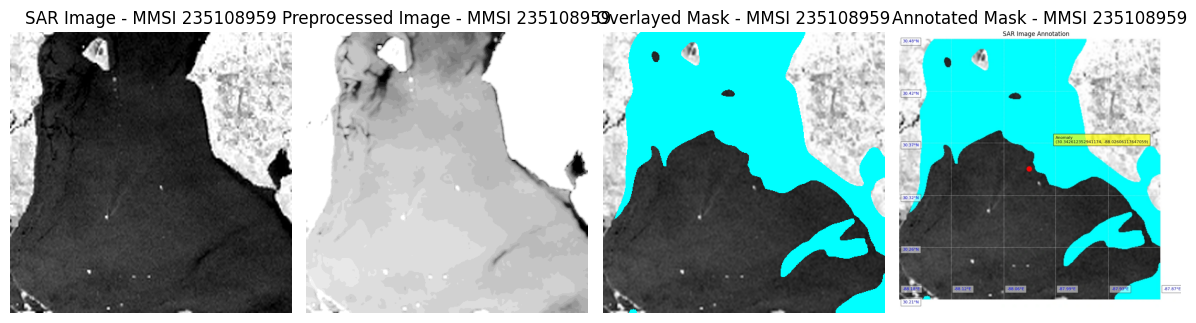

MMSI                              215215000
TimeWindow              2023-11-16 06:40:00
SOG_mean                          16.168421
COG_mean                         135.326316
LAT_mean                          29.333454
LON_mean                         -89.397358
VesselType_mode                        71.0
Heading_mean_heading              134.82859
Cargo_mode                             71.0
Status_mode                             0.0
TimeOfDay_mode                      Morning
is_anomaly                             True
anomaly_probability              0.49074456
Predicted_Class                         1.0
Name: 18, dtype: object


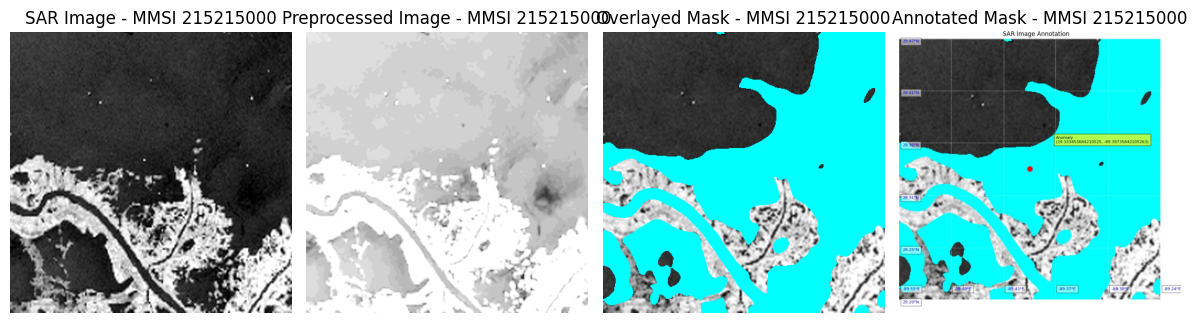

MMSI                              366966060
TimeWindow              2023-11-16 00:00:00
SOG_mean                           0.083333
COG_mean                         226.916667
LAT_mean                          29.857153
LON_mean                         -85.377208
VesselType_mode                        31.0
Heading_mean_heading              51.328241
Cargo_mode                             31.0
Status_mode                             1.0
TimeOfDay_mode                        Night
is_anomaly                             True
anomaly_probability               0.3772717
Predicted_Class                         1.0
Name: 29, dtype: object


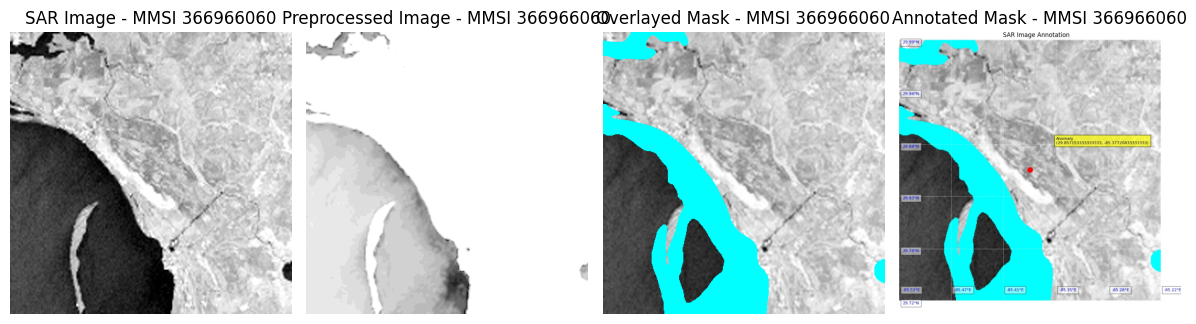

In [26]:
import matplotlib.pyplot as plt
import base64
import io
from PIL import Image

# Iterate over each row in the DataFrame
num_rows = test_df.shape[0]

for i in range(num_rows):
    # Print details for the current row
    print(test_df[['MMSI', 'TimeWindow', 'SOG_mean', 'COG_mean', 'LAT_mean', 'LON_mean',
                    'VesselType_mode', 'Heading_mean_heading', 'Cargo_mode', 'Status_mode',
                    'TimeOfDay_mode', 'is_anomaly', 'anomaly_probability', 'Predicted_Class']].iloc[i])
    
    # Create a figure with subplots for images
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 5))

    # Get the SAR image from the DataFrame
    sar_image_base64 = test_df['SAR_image'].iloc[i]
    preprocessed_image_base64=test_df['Preprocessed_Image'].iloc[i]
    overlayed_image_base64 = test_df['Overlayed_Mask'].iloc[i]
    annotated_image_base64=test_df['Annotated_Image'].iloc[i]

    # Plot SAR Image
    if sar_image_base64:
        sar_image_data = base64.b64decode(sar_image_base64)
        sar_img = Image.open(io.BytesIO(sar_image_data))
        axes[0].imshow(sar_img, cmap='gray')
        axes[0].set_title(f"SAR Image - MMSI {test_df['MMSI'].iloc[i]}")
        axes[0].axis('off')  # Hide axes ticks
    else:
        axes[0].set_title(f"SAR Image - MMSI {test_df['MMSI'].iloc[i]} (No Image)")
        axes[0].axis('off')  # Hide axes ticks
    
    # Plot Preprocessed Image
    if sar_image_base64:
        preprocessed_image_data = base64.b64decode(preprocessed_image_base64)
        preprocessed_img = Image.open(io.BytesIO(preprocessed_image_data))
        axes[1].imshow(preprocessed_img, cmap='gray')
        axes[1].set_title(f"Preprocessed Image - MMSI {test_df['MMSI'].iloc[i]}")
        axes[1].axis('off')  # Hide axes ticks
    else:
        axes[1].set_title(f"Preprocessed Image - MMSI {test_df['MMSI'].iloc[i]} (No Image)")
        axes[1].axis('off')  # Hide axes ticks

    # Plot Overlayed Image
    if overlayed_image_base64:
        overlayed_image_data = base64.b64decode(overlayed_image_base64)
        overlayed_img = Image.open(io.BytesIO(overlayed_image_data))
        axes[2].imshow(overlayed_img)
        axes[2].set_title(f"Overlayed Mask - MMSI {test_df['MMSI'].iloc[i]}")
        axes[2].axis('off')  # Hide axes ticks
    else:
        axes[2].set_title(f"Overlayed Mask - MMSI {test_df['MMSI'].iloc[i]} (No Image)")
        axes[2].axis('off')  # Hide axes ticks
    
    # Plot Annotated Image
    if annotated_image_base64:
        annotated_image_data = base64.b64decode(annotated_image_base64)
        annotated_img = Image.open(io.BytesIO(annotated_image_data))
        axes[3].imshow(annotated_img)
        axes[3].set_title(f"Annotated Mask - MMSI {test_df['MMSI'].iloc[i]}")
        axes[3].axis('off')  # Hide axes ticks
    else:
        axes[3].set_title(f"Annotated Mask - MMSI {test_df['MMSI'].iloc[i]} (No Image)")
        axes[3].axis('off')  # Hide axes ticks

    plt.tight_layout()
    plt.show()  # Display the images